<a href="https://colab.research.google.com/github/coordanalisis-sedatu/datavivi/blob/main/datos_cierre_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
    ##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,googledrive,janitor,survey,webshot2,
               showtext,sf, httr,jsonlite,gt,ggrepel,magick,gt)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

## Funciones para ahorrar código

In [58]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [59]:
#Función para crear mapas
crea_mapa <- function(df, custom_palette, titulo, geodataframe) {
  library(tidyverse)
  library(sf)


  datos_planos<-df%>%
    #Crear periodos
    mutate(periodo=case_when(año>=2013 & año<=2018~"2013-2018",
                             año>=2019 & año<=2023~"2019-2023"))%>%
    group_by(periodo,estado)%>%
    summarise(acciones=sum(acciones),monto=sum(monto))%>%
    ungroup()%>%
    #Crear distribución porcentual
    group_by(periodo)%>%
    mutate(porcentaje=round(acciones/sum(acciones)*100,2))%>%
    ungroup()%>%
    #Crear cortes para la distribución
    mutate(acciones_cat=cut(porcentaje,breaks=5, dig.lab=2))%>%
    #Formato de etiquetas
    mutate(
      etiquetas = if_else(
        str_detect(acciones_cat, "^\\([-]"),
        str_replace(as.character(acciones_cat), "^\\(\\-", "("),
        as.character(acciones_cat)
      ),
      #Guión en lugar de coma
      etiquetas = str_replace(etiquetas, ",", "-"),
      etiquetas = str_replace(etiquetas, "\\]$", ")")
    )%>%
    #Unir con geodataframe
    left_join(geodataframe, by = c("estado" = "state_name"))

  geodata<-datos_planos%>%
    st_as_sf()

  #Crear mapa
  ggplot() +
    # Capa con datos de los municipios
    geom_sf(data=geodata,aes(fill = etiquetas),
            colour = "#ffffff", size = 0.07) +
    # Agrega título, subtítulo y fuente
    labs(title = titulo,
         subtitle="(Porcentaje)",
         caption = "
Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).") +
    scale_fill_manual("%",values = custom_palette)+
    guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
    theme(plot.title = element_text(hjust = 0, size=25,face="bold"),
          plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
          plot.caption = element_text(hjust = 0,size=15),
          legend.position="right",
          #Fuente y tamaño
          text=element_text("pop",
                            size=20))+
    facet_wrap(~periodo)

}


In [60]:

#Función para crear tabla
crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df %>%
    mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }

  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold",
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#235b4eff",
      column_labels.font.size = 10,
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("Nota: Cifras preliminares.")
    ) %>%
    tab_source_note(
      source_note = md(nota)
    ) %>%
    tab_source_note(
      source_note = md("Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).")
    )%>%
    cols_width(
      everything() ~ px(80)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}


In [61]:

#Función para agrupar datos de manera anual
agrupa_dato_anual <- function(df, columna_tipo_dato) {
  library(dplyr)
  #Condición de agrupación
  if("organismo" %in% names(df)) {
    grouped_df <- df %>%
      group_by(año, organismo)
  } else {
    grouped_df <- df %>%
      group_by(año)
  }

  result_df <- grouped_df %>%
    summarise(
      monto = round(sum(monto) / 1000000, 1),
      acciones = sum(acciones),
      .groups = 'drop'
    ) %>%
    mutate(año = as.character(año)) %>%
    rename(
      "Año" = año,
      "Monto (millones de pesos)" = monto,
      !!columna_tipo_dato := acciones
    )


  #Renombrar organismo
  if("organismo" %in% names(df)) {
    result_df <- result_df %>%
      rename("Organismo" = organismo)
  }

  return(result_df)
}



In [62]:
#Función para actualizar los precios

actualiza_precios<-function(df,tabla_inpc){

  df<-df%>%
    #Pegar con tabla de inpc
    left_join(tabla_inpc, by = c("año" = "año"))%>%
    #Calcular precios actualizados
    #Utilizar columna Monto (millones de pesos) y multiplicar por el inpc correspondiente
    mutate(monto_actualizado=round(monto*inpc23/100,2))

  return(df)

}

In [63]:
# Función para gráfica de línea de acciones y monto
grafevolacc <- function(df, org, variable_name) {
  data <- df %>%
    filter(año != 2024, organismo == org) %>%
    group_by(año) %>%
    summarise(acciones = sum(creditos), monto = sum(monto)) %>%
    ungroup() %>%
    actualiza_precios(inpc) %>%
    mutate(monto_actualizado = monto_actualizado / 1000000) %>%
    select(año, acciones, monto_actualizado) %>%
    rename(monto = monto_actualizado) %>%
    pivot_longer(cols = c(acciones, monto), names_to = "variable", values_to = "value") %>%
    filter(variable == variable_name)

  # Puntos de inicio y fin
  first_last_points <- data %>%
    filter(año == min(año) | año == max(año))

  #
  p <- ggplot(data, aes(x = año, y = value, group = variable)) +
    geom_line(aes(color = variable), size = 2) +
    geom_point(data = first_last_points, size = 3) #Puntos solo para inicio y fin

  # Si es INSUS no se presenta línea horizontal
  if (org != "INSUS") {
    p <- p + geom_vline(xintercept = 2018, color = "black", linetype = "dashed", size = 1)
  }


  p <- p +
    geom_text_repel(data = first_last_points, aes(label = scales::label_comma()(value)), nudge_y = 0.05 * max(data$value), size = 5) +
    scale_color_manual(values = set_names(c("#235b4e", "#bc955c"), c("acciones", "monto"))) +
    theme_minimal() +
    labs(x = "Año", y = variable_name, title = paste("Evolución de ", variable_name, "de ", org)) +
    scale_x_continuous(breaks = function(x) unique(floor(pretty(x))), labels = scales::label_number(auto = TRUE)) +
    scale_y_continuous(labels = scales::label_comma()) +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "none",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 90, hjust = 0.95, vjust = 0.2),
      axis.text.y = element_text(size = 12)
    )

  return(p)
}

In [142]:
crea_grafbarra <- function(data, group_var) {
  colores <- c("#235b4e", "#bc955c", "#98989a", "#9f2241", "#ddc9a3", "#6A8EAE", "#333333")

  
  # Prepare the data
  processed_data <- data %>%
    filter(año != 2024) %>%
    mutate(periodo = case_when(
      año >= 2013 & año <= 2018 ~ "2013-2018",
      año >= 2019 & año <= 2023 ~ "2019-2023"
    )) %>%
    group_by(periodo, {{ group_var }}) %>%
    summarise(acciones = sum(creditos, na.rm = TRUE), monto = sum(monto, na.rm = TRUE)) %>%
    ungroup() %>%
    group_by(periodo) %>%
    mutate(porcentaje = round(acciones / sum(acciones) * 100, 1)) %>%
    ungroup()
  
  # Create the bar chart with the processed data
  p <- ggplot(processed_data, aes(x = periodo, y = porcentaje, fill = {{ group_var }})) + 
    geom_bar(stat = "identity", position = position_dodge(width = 0.9)) +
    geom_text(aes(label = porcentaje), vjust = -0.5, position = position_dodge(width = 0.9), size = 5) +
    scale_fill_manual(values = colores) +
    labs(x = "Periodo", y = "Porcentaje de Acciones", fill = as.character(rlang::as_label(rlang::enquo(group_var)))) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0, size = 20, face = "bold"),
      plot.subtitle = element_text(hjust = 0, size = 15, face = "italic"),
      plot.caption = element_text(hjust = 0, size = 10),
      legend.position = "right",
      axis.ticks = element_blank(),
      axis.title = element_text(size = 15),
      axis.text.x = element_text(size = 12, angle = 0, hjust = 0.95, vjust = 0.2),
      axis.text.y = element_text(size = 12),
      text = element_text(family = "pop")
    )
  
  return(p)
}


In [64]:
paleta<-rev(c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff"))

## Cartografía para generar los mapas

In [65]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))
estados

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called 'geojsonio'

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,id,state_code,state_name,geometry
,<chr>,<int>,<chr>,<MULTIPOLYGON [°]>
1,NA,9,Ciudad de México,MULTIPOLYGON (((-99.09052 1...
2,NA,12,Guerrero,MULTIPOLYGON (((-100.5388 1...
3,NA,15,México,MULTIPOLYGON (((-99.85919 2...
4,NA,17,Morelos,MULTIPOLYGON (((-99.06199 1...
5,NA,25,Sinaloa,MULTIPOLYGON (((-108.4705 2...
6,NA,2,Baja California,MULTIPOLYGON (((-115.2138 2...
7,NA,26,Sonora,MULTIPOLYGON (((-112.5544 2...
8,NA,3,Baja California Sur,MULTIPOLYGON (((-109.8005 2...
9,NA,32,Zacatecas,MULTIPOLYGON (((-101.6003 2...


### Índice Nacional de Precios al Consumidor

In [66]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"

In [67]:
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2013/01" & time_period <= "2023/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Dejar solo los datos de diciembre
filter(mes=="12")%>%
arrange(año)%>%
select(año,mes,obs_value)%>%
mutate(
#Cambiar base a 2023
inpc23=obs_value/obs_value[11]*100)%>%
  mutate(año=as.integer(año))
inpc

año,mes,obs_value,inpc23
<int>,<chr>,<dbl>,<dbl>
2013,12,83.77006,63.28334
2014,12,87.18898,65.86614
2015,12,89.04682,67.26962
2016,12,92.03903,69.53007
2017,12,98.27288,74.23937
2018,12,103.02000,77.82554
2019,12,105.93400,80.02689
2020,12,109.27100,82.54780
2021,12,117.30800,88.61928


In [68]:
#leer datos de la solicitud

data<-read.csv("https://raw.githubusercontent.com/coordanalisis-sedatu/datavivi/main/solicitud.csv")%>%
  #Construir clavegeostadística
  ##Agregar cero a entidad
  mutate(cve_ent=ifelse(nchar(cve_ent)==1,
                        paste0("0",cve_ent),
                    cve_ent))%>%
  ##Agregar ceros a municipio
  mutate(cve_mun=ifelse(nchar(cve_mun)==1,
                        paste0("00",cve_mun),
                        ifelse(nchar(cve_mun)==2,
                               paste0("0",cve_mun),
                               cve_mun)))%>%
  ##Crear clave geoestadística
  mutate(cvegeo=paste0(cve_ent,cve_mun))%>%
      mutate(estado = case_when(
    cve_ent == "01" ~ "Aguascalientes",
    cve_ent == "02" ~ "Baja California",
    cve_ent == "03" ~ "Baja California Sur",
    cve_ent == "04" ~ "Campeche",
    cve_ent == "05" ~ "Coahuila de Zaragoza",
    cve_ent == "06" ~ "Colima",
    cve_ent == "07" ~ "Chiapas",
    cve_ent == "08" ~ "Chihuahua",
    cve_ent == "09" ~ "Ciudad de México",
    cve_ent == "10" ~ "Durango",
    cve_ent == "11" ~ "Guanajuato",
    cve_ent == "12" ~ "Guerrero",
    cve_ent == "13" ~ "Hidalgo",
    cve_ent == "14" ~ "Jalisco",
    cve_ent == "15" ~ "México",
    cve_ent == "16" ~ "Michoacán de Ocampo",
    cve_ent == "17" ~ "Morelos",
    cve_ent == "18" ~ "Nayarit",
    cve_ent == "19" ~ "Nuevo León",
    cve_ent == "20" ~ "Oaxaca",
    cve_ent == "21" ~ "Puebla",
    cve_ent == "22" ~ "Querétaro",
    cve_ent == "23" ~ "Quintana Roo",
    cve_ent == "24" ~ "San Luis Potosí",
    cve_ent == "25" ~ "Sinaloa",
    cve_ent == "26" ~ "Sonora",
    cve_ent == "27" ~ "Tabasco",
    cve_ent == "28" ~ "Tamaulipas",
    cve_ent == "29" ~ "Tlaxcala",
    cve_ent == "30" ~ "Veracruz de Ignacio de la Llave",
    cve_ent == "31" ~ "Yucatán",
    cve_ent == "32" ~ "Zacatecas",
    TRUE ~ NA_character_
  ))
data

año,organismo,cve_ent,cve_mun,destino,nivel_salarial,sexo,edad,creditos,monto,cvegeo,estado
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>
2013,CONAVI,01,001,Mejoramientos,2.61 a 4.00,Hombre,30 a 59,2,22400.00,01001,Aguascalientes
2013,CONAVI,01,001,Mejoramientos,2.61 a 4.00,Mujer,29 o menos,1,4800.00,01001,Aguascalientes
2013,CONAVI,01,001,Mejoramientos,2.61 a 4.00,Mujer,30 a 59,2,22400.00,01001,Aguascalientes
2013,CONAVI,01,001,Mejoramientos,2.6 o menos,Hombre,30 a 59,1,6000.00,01001,Aguascalientes
2013,CONAVI,01,001,Mejoramientos,2.6 o menos,Mujer,30 a 59,1,6000.00,01001,Aguascalientes
2013,CONAVI,01,001,Mejoramientos,4.01 a 6.00,Hombre,29 o menos,1,8000.00,01001,Aguascalientes
2013,CONAVI,01,001,Vivienda existente,2.61 a 4.00,Hombre,29 o menos,3,188995.56,01001,Aguascalientes
2013,CONAVI,01,001,Vivienda existente,2.61 a 4.00,Hombre,30 a 59,8,503988.16,01001,Aguascalientes
2013,CONAVI,01,001,Vivienda existente,2.61 a 4.00,Hombre,60 o más,1,62998.52,01001,Aguascalientes


In [69]:
unique(data$cve_ent)

[1] "01" "02" "03" "04" "05" "06" "07" "08" "09" "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "00"

# Resultados

## General

In [70]:
gral<-data%>%
  filter(año!=2024)%>%
  group_by(año,cvegeo,estado)%>%
  summarise(acciones=sum(creditos),
monto=sum(monto)
)%>%
  ungroup()

`summarise()` has grouped output by 'año', 'cvegeo'. You can override using the
`.groups` argument.


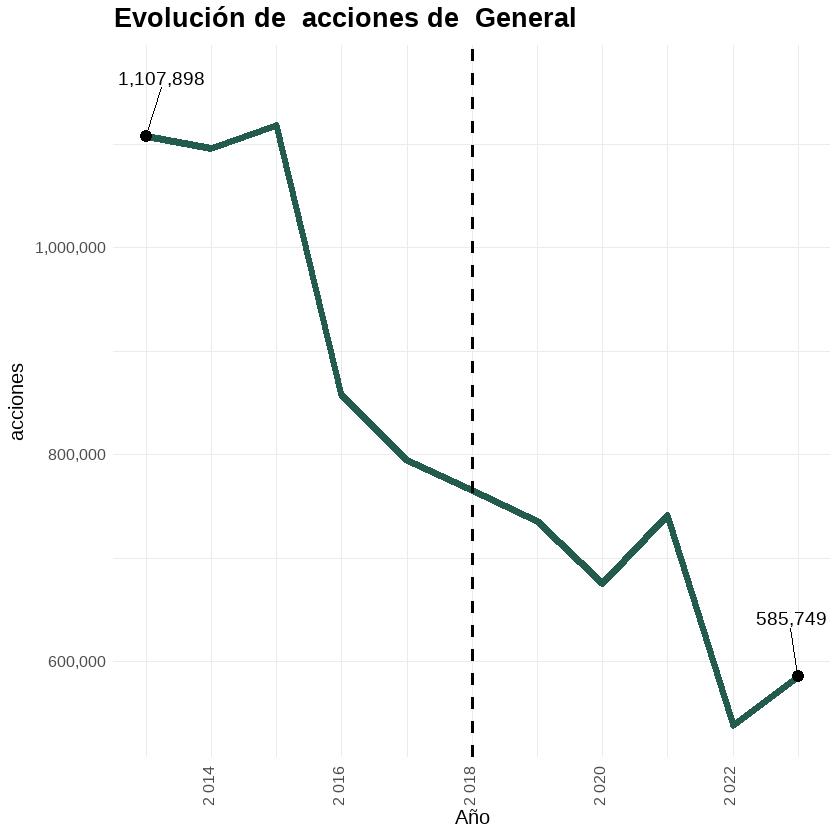

In [84]:
data%>%
  filter(año!=2024)%>%
mutate(organismo="General")%>%
grafevolacc("General","acciones")
ggsave("evol_acciones_gral.png",width = 10, height = 6, bg="white", dpi=100)

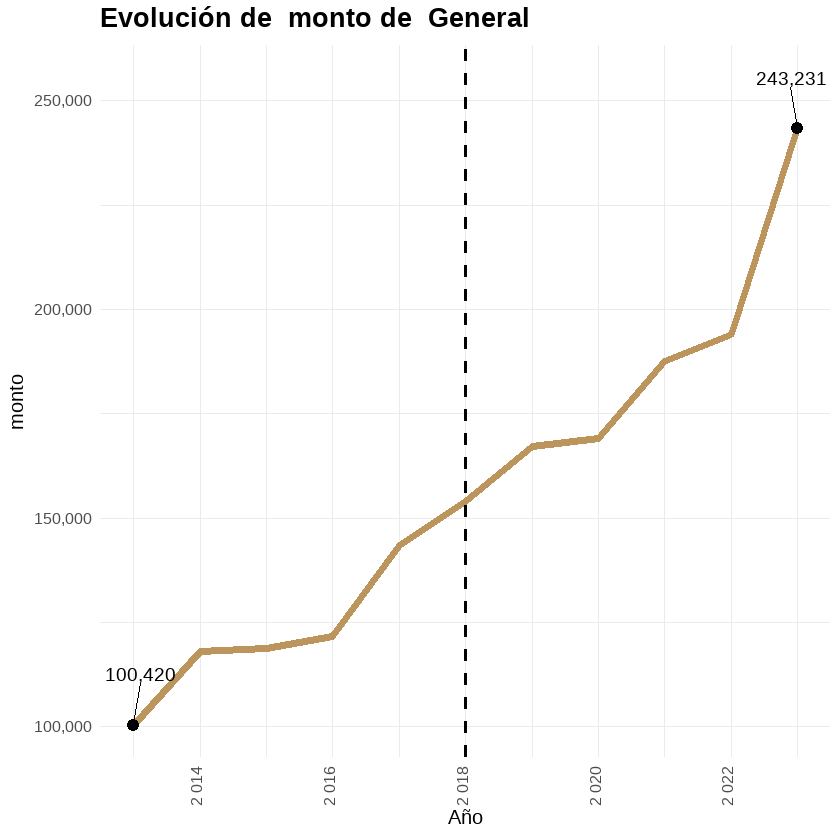

In [85]:
data%>%
  filter(año!=2024)%>%
mutate(organismo="General")%>%
grafevolacc("General","monto")
ggsave("evol_monto_gral.png",width = 10, height = 6, bg="white", dpi=100)

In [75]:
mapgral<-crea_mapa(gral, paleta, "Financiamientos ONAVIS, 2013-2023",estados)

ggsave(paste0("map_general.png"), plot = mapgral, width = 6, height = 4, dpi = 300)

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


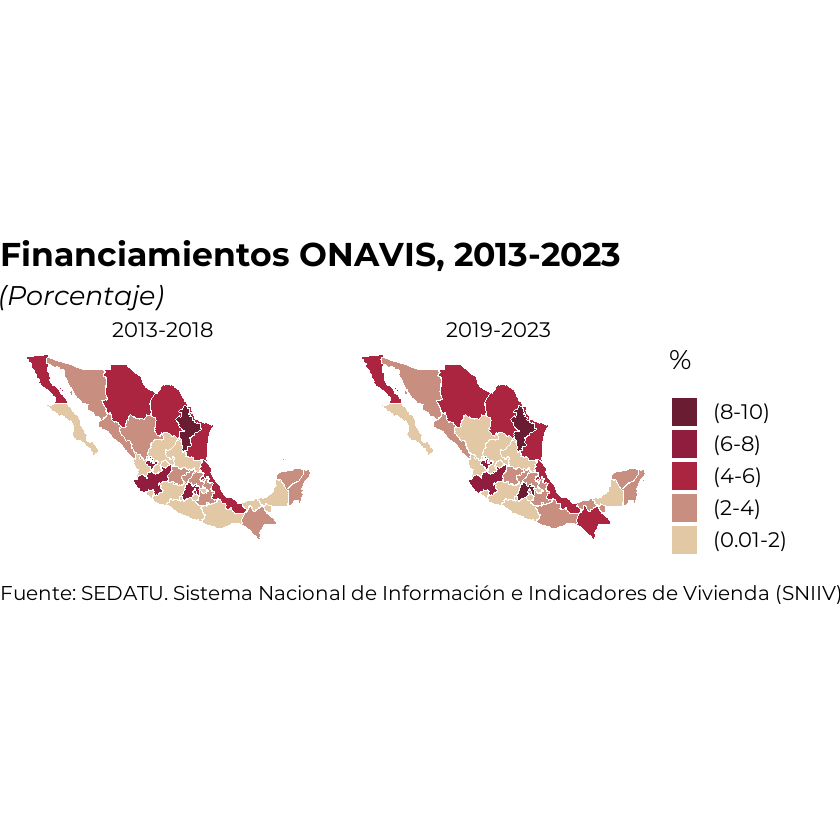

In [76]:
mapgral

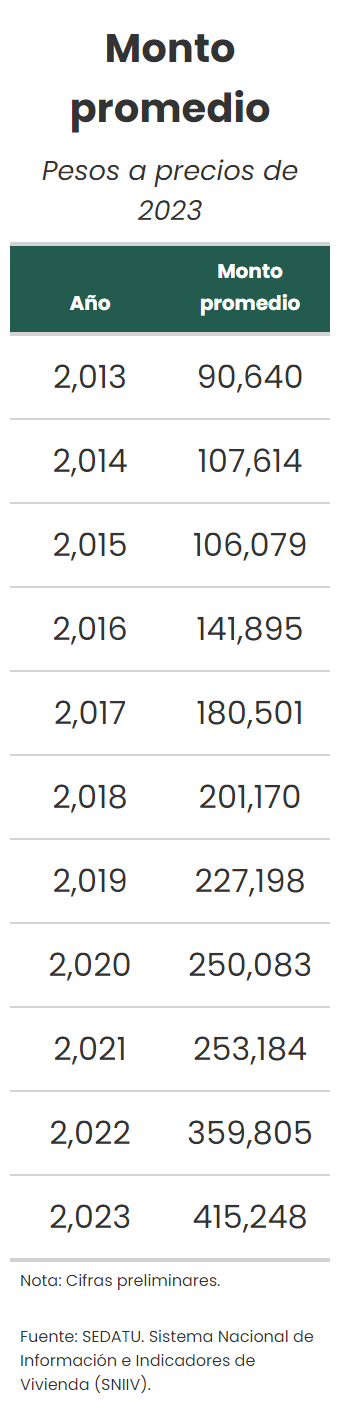

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      340   1416 sRGB       TRUE     76890 72x72  

In [77]:
data%>%

  filter(año!=2024)%>%
group_by(año)%>%
      summarise(acciones = sum(creditos), monto = sum(monto)) %>%
    ungroup() %>%
    actualiza_precios(inpc) %>%
    select(año, acciones, monto_actualizado)%>%
    mutate(monto_prom=monto_actualizado/acciones)%>%
select(año,monto_prom)%>%
  rename(`Monto promedio` = monto_prom,
Año = año)%>%
    crea_tabla("Monto promedio","Pesos a precios de 2023",nota="","monto_prom_gral.png")

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


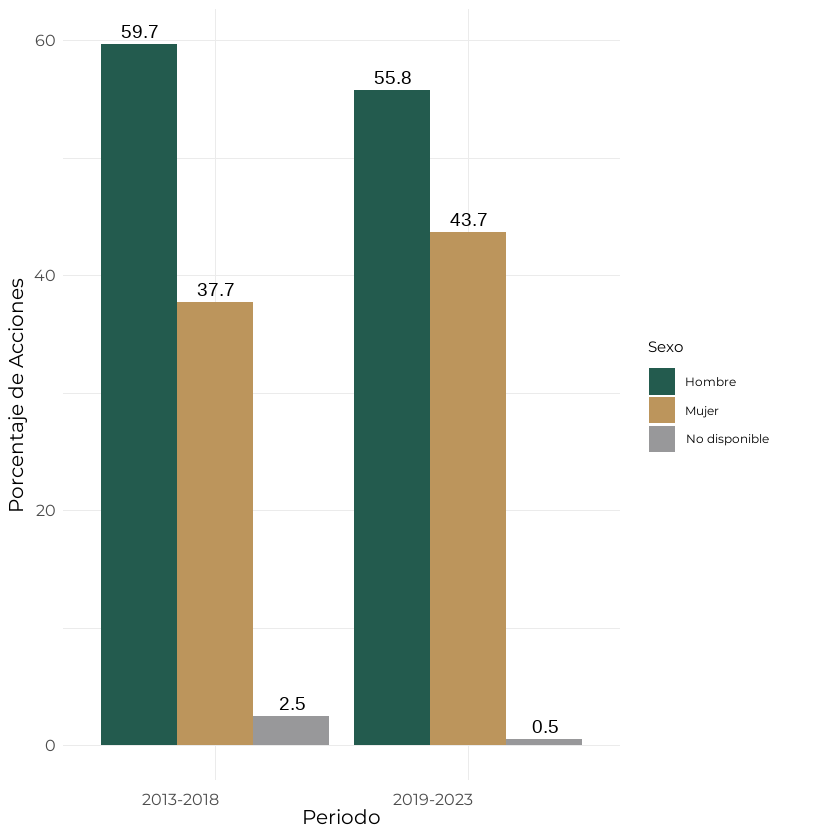

In [137]:
crea_grafbarra(data%>%rename(Sexo=sexo), Sexo)
ggsave("generogral.png",width = 10, height = 6, bg="white", dpi=100)

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


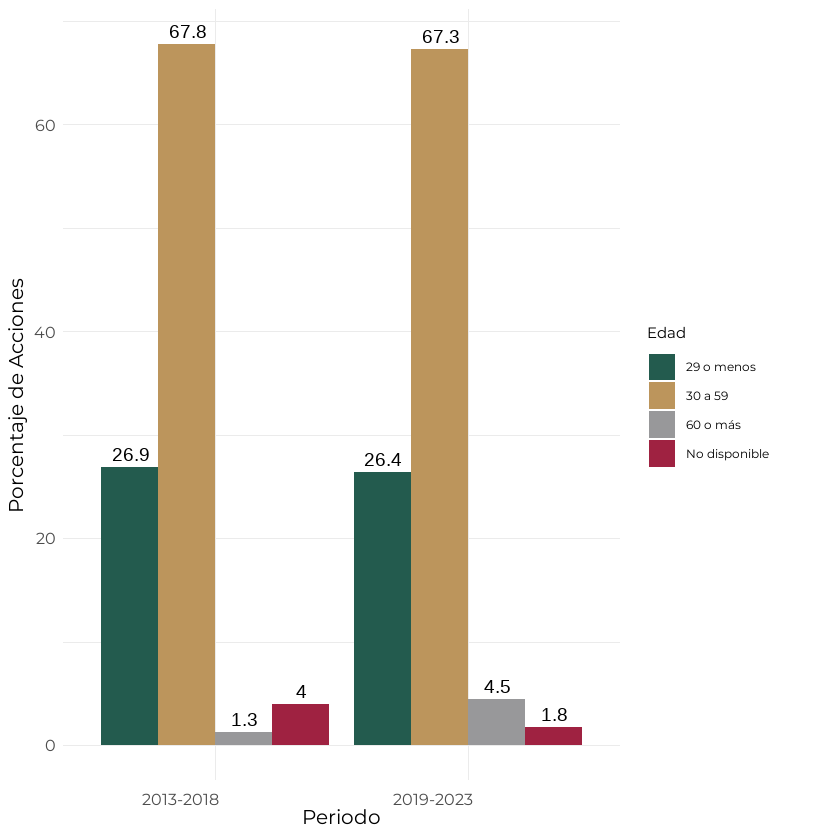

In [131]:
crea_grafbarra(data%>%rename(Edad=edad), Edad)
ggsave("edadgral.png",width = 10, height = 6, bg="white", dpi=100)


`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


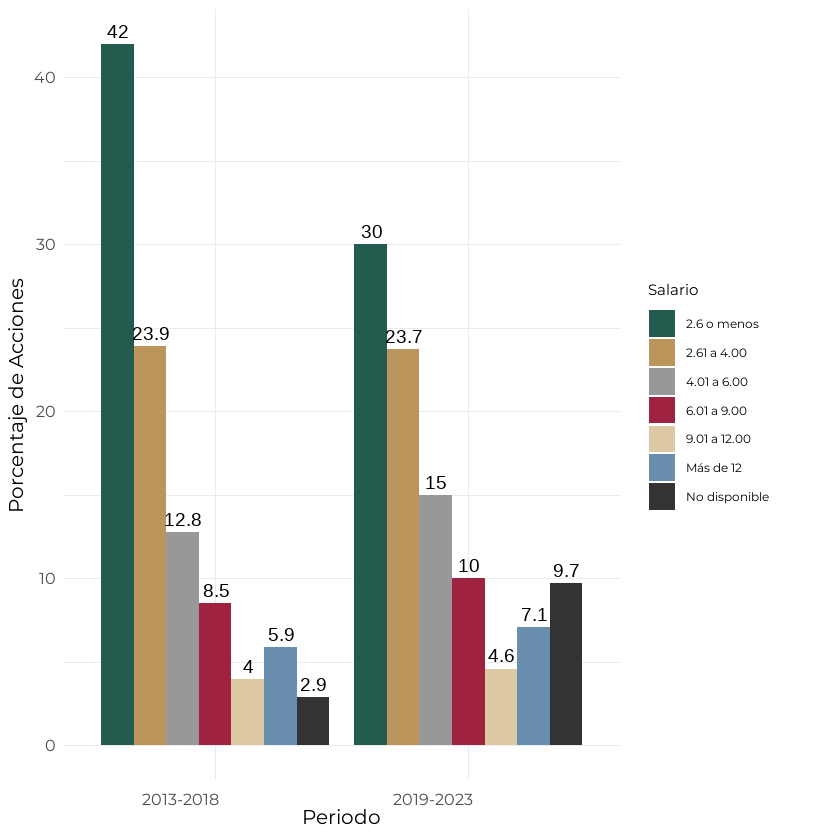

In [143]:
crea_grafbarra(data%>%rename(Salario=nivel_salarial), Salario)
ggsave("salariogral.png",width = 10, height = 6, bg="white", dpi=100)

## Por organismo

In [78]:
datamapa<-data%>%
  filter(año!=2024)%>%
  group_by(año,organismo,cvegeo,estado)%>%
  summarise(acciones=sum(creditos),
monto=sum(monto)
)%>%
  ungroup()

`summarise()` has grouped output by 'año', 'organismo', 'cvegeo'. You can
override using the `.groups` argument.


In [79]:
#Lista de organismos
lista<-unique(datamapa$organismo)
lista

[1] "CONAVI"       "FOVISSSTE"    "INFONAVIT"    "SHF (FONDEO)" "INSUS"

In [80]:
lista<-unique(datamapa$organismo)
titulo <- "Fin"

for (org in lista) {
  # filtro
  df_organismo <- datamapa %>%
    filter(org == organismo)

  # Llama a al función.
  mapa <- crea_mapa(df_organismo, paleta, org, estados)

  # Salva el mapa.
  ggsave(paste0("map_", org, ".png"), plot = mapa, width = 11, height = 8.5, dpi = 100)
}


`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


## Evolución en el tiempo
### Acciones y monto

In [81]:
#Lista de plots
plot_list <- list()

# Loop
for (org in lista) {
  for (var in c("acciones", "monto")) {
    # Función de gráfica
    plot <- grafevolacc(data, org, var)
    # Añadir plot a la lista
    plot_name <- paste(org, var, sep = "_")
    plot_list[[plot_name]] <- plot
  }
}

for (name in names(plot_list)) {
  ggsave(paste0(name, ".png"), plot_list[[name]], width = 10, height = 6, bg="white", dpi=100)
}

# Nombres de los gráficos
names(plot_list)

[1] "CONAVI_acciones"       "CONAVI_monto"          "FOVISSSTE_acciones"   
 [4] "FOVISSSTE_monto"       "INFONAVIT_acciones"    "INFONAVIT_monto"      
 [7] "SHF (FONDEO)_acciones" "SHF (FONDEO)_monto"    "INSUS_acciones"       
[10] "INSUS_monto"

### Monto promedio

In [0]:
# Loop para monto promedio
for (org in lista) {

  organismo_data <- data %>%
    filter(org == organismo) %>%
    filter(año != 2024) %>%
    group_by(año) %>%
    summarise(acciones = sum(creditos), monto = sum(monto)) %>%
    ungroup() %>%
    actualiza_precios(inpc) %>%
    select(año, acciones, monto_actualizado) %>%
    mutate(monto_prom = monto_actualizado / acciones) %>%
    select(año, monto_prom) %>%
    rename(`Monto promedio` = monto_prom, `Año` = año)

  # Invoca función para crear tabla
  crea_tabla(organismo_data, "Monto promedio", "Pesos a precios de 2023", nota = "", paste0(org, "_monto_prom.png"))
}


## Género

In [138]:
plot_list <- list()

for (org in lista) {
  plot <- crea_grafbarra(data %>% filter(organismo == org) %>% rename(Sexo = sexo), Sexo)
  plot_list[[org]] <- plot
}

for (name in names(plot_list)) {
  ggsave(paste0(name, "_genero.png"), plot_list[[name]], width = 10, height = 6, bg="white", dpi=100)
}



`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


[1] "CONAVI"       "FOVISSSTE"    "INFONAVIT"    "SHF (FONDEO)" "INSUS"

## Edad

In [139]:
plot_list <- list()

for (org in lista) {
  plot <- crea_grafbarra(data %>% filter(organismo == org) %>% rename(Edad = edad), Edad)
  plot_list[[org]] <- plot
}

for (name in names(plot_list)) {
  ggsave(paste0(name, "_edad.png"), plot_list[[name]], width = 10, height = 6, bg="white", dpi=100)
}


`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


## Ingresos

In [144]:
plot_list <- list()

for (org in lista) {
  plot <- crea_grafbarra(data %>% filter(organismo == org) %>% rename(Salario = nivel_salarial), Salario)
  plot_list[[org]] <- plot
}

for (name in names(plot_list)) {
  ggsave(paste0(name, "_salario.png"), plot_list[[name]], width = 10, height = 6, bg="white", dpi=100)
}


`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


## Avance 2024 - enero y febrero

In [ ]:
data%>%
  filter(año==2024)%>%
group_by(organismo)%>%
      summarise(acciones = sum(creditos), monto = sum(monto)/1000000) %>%
    ungroup() 

In [ ]:
data%>%
  filter(año==2024)%>%

      summarise(acciones = sum(creditos), monto = sum(monto)/1000000) %>%
    ungroup() 